In [1]:
#%load_ext cudf.pandas

# To desable GPU usage
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

#from cucim.skimage.exposure import rescale_intensity
import tensorflow as tf
#import cupy as cp
#import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
import gc

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # memory limit 16GB (16 * 1024 MB = 16384 MB) 
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=16384)] 
        )
        print("Set GPU memory limit to 16GB.")
    except RuntimeError as e:
        print("Error setting memory limit:", e)
else:
    print("No GPUs available.")

#print("Is torch using cuda? ",torch.cuda.is_available())
print("Is tensorflow using cuda? ",tf.test.is_built_with_cuda())
print("Is pandas using cuda? ",pd)


2024-11-19 07:44:34.127519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 07:44:34.158975: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 07:44:34.168648: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 07:44:34.194137: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Set GPU memory limit to 16GB.
Is tensorflow using cuda?  True
Is pandas using cuda?  <module 'pandas' from '/usr/local/lib/python3.11/dist-packages/pandas/__init__.py'>


In [2]:
name_mapping = [
    "box",
    "circularTorus",
    "cone",
    "coneOffset",
    "cylinder",
    "cylinderSlope",
    "dish",
    "mesh",
    "pyramid",
    "rectangularTorus",
    "sphere"
]

In [3]:
num_classes = 11
def filter_invalid_labels(image, label):
    # Exclude labels that are less than 0 or greater than the maximum allowed class
    valid_labels = tf.reduce_all(label >= 0) & tf.reduce_all(label < num_classes)
    return valid_labels

In [4]:
base_path = '/home/workspace/geometry-classifier/data/'

def parse_tfrecord(example_proto):
    """Parse a single TFRecord example."""
    feature_description = {
        'name': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    name = tf.io.decode_raw(parsed_example['name'], tf.float32)
    image = tf.io.decode_raw(parsed_example['image'], tf.float32)
    image = tf.reshape(image, (224, 224, 1))  # Reshape image data to 224x224x3
    class_label = tf.cast(name[0], tf.int32)  # Use the first byte as a class label
    return image, class_label

def load_tfrecord(tfrecord_files):
    """Load TFRecords and prepare a dataset."""
    raw_dataset = tf.data.TFRecordDataset(tfrecord_files, compression_type="GZIP")
    parsed_dataset = raw_dataset.map(parse_tfrecord)
    return parsed_dataset

# Directory with TFRecords

files_for = lambda file_type: glob.glob(f"{base_path}/tfrecord2/{file_type}*.tfrecord.gz")

test_files = files_for("test")
validation_files = files_for("val")
train_files = files_for("train")

print(glob.glob(f"{base_path}tfrecord2/*.tfrecord.gz")[0])

test = load_tfrecord(test_files).filter(filter_invalid_labels)
test = test.batch(32).prefetch(tf.data.AUTOTUNE)

validation = load_tfrecord(validation_files).filter(filter_invalid_labels)
validation = validation.batch(32).prefetch(tf.data.AUTOTUNE)

train = load_tfrecord(train_files).filter(filter_invalid_labels)
train = train.shuffle(23360).batch(32).prefetch(tf.data.AUTOTUNE)



/home/workspace/geometry-classifier/data/tfrecord2/train462.tfrecord.gz


2024-11-19 07:44:39.484183: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16384 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:23:00.0, compute capability: 7.5


In [5]:
# 224 x 224

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

model = models.Sequential([
    layers.Conv2D(8, (3, 3), activation='relu', input_shape=(224,224,1)),
    layers.MaxPooling2D((2, 2)),
    

    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    

    layers.Flatten(),
    
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(11, activation='softmax') 
])

model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
checkpoint_callback = ModelCheckpoint(base_path+'model3.keras',save_best_only=True, save_weights_only=False, mode='min', verbose=1)
early_stopping = EarlyStopping(
    monitor="val_loss",       # Monitor validation loss
    patience=5,               # Wait for 5 epochs without improvement
    restore_best_weights=True,  # Restore the best model weights
    verbose=1
)

epochs = 100

In [7]:

cnn = model.fit(train, epochs=epochs,callbacks=[
    early_stopping,
    checkpoint_callback
], validation_data=validation)

Epoch 1/100


I0000 00:00:1732002282.460941    1320 service.cc:146] XLA service 0x7f0198005450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732002282.461026    1320 service.cc:154]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2024-11-19 07:44:42.535053: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-19 07:44:43.001551: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


      8/Unknown 6s 20ms/step - accuracy: 0.1574 - loss: 2.3958

I0000 00:00:1732002286.577312    1320 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  23359/Unknown 626s 27ms/step - accuracy: 0.9188 - loss: 0.2496

2024-11-19 07:55:06.820876: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-19 07:55:06.820983: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-19 07:55:06.821011: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 07:55:06.821117: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, trac


Epoch 1: val_loss improved from inf to 0.00624, saving model to /home/workspace/geometry-classifier/data/model2.keras
23360/23360 ━━━━━━━━━━━━━━━━━━━━ 844s 36ms/step - accuracy: 0.9188 - loss: 0.2496 - val_accuracy: 0.9983 - val_loss: 0.0062
Epoch 2/100


2024-11-19 07:58:43.751977: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-19 07:58:43.752086: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 07:58:43.752113: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911


23359/23360 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9955 - loss: 0.0137

2024-11-19 08:09:18.784401: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 08:09:18.784532: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911



Epoch 2: val_loss improved from 0.00624 to 0.00241, saving model to /home/workspace/geometry-classifier/data/model2.keras
23360/23360 ━━━━━━━━━━━━━━━━━━━━ 849s 36ms/step - accuracy: 0.9955 - loss: 0.0137 - val_accuracy: 0.9991 - val_loss: 0.0024
Epoch 3/100


2024-11-19 08:12:52.502755: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-19 08:12:52.502872: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 08:12:52.502960: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911


23359/23360 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9972 - loss: 0.0080
Epoch 3: val_loss improved from 0.00241 to 0.00195, saving model to /home/workspace/geometry-classifier/data/model2.keras
23360/23360 ━━━━━━━━━━━━━━━━━━━━ 858s 37ms/step - accuracy: 0.9972 - loss: 0.0080 - val_accuracy: 0.9993 - val_loss: 0.0020
Epoch 4/100


2024-11-19 08:27:10.529689: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 08:27:10.529823: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911


23358/23360 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9979 - loss: 0.0060

2024-11-19 08:37:43.466487: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 08:37:43.466581: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911



Epoch 4: val_loss improved from 0.00195 to 0.00173, saving model to /home/workspace/geometry-classifier/data/model2.keras
23360/23360 ━━━━━━━━━━━━━━━━━━━━ 855s 37ms/step - accuracy: 0.9979 - loss: 0.0060 - val_accuracy: 0.9993 - val_loss: 0.0017
Epoch 5/100


2024-11-19 08:41:25.605390: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-19 08:41:25.605485: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 08:41:25.605539: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911


23360/23360 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9981 - loss: 0.0049

2024-11-19 08:51:51.515207: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 08:51:51.515345: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911



Epoch 5: val_loss improved from 0.00173 to 0.00164, saving model to /home/workspace/geometry-classifier/data/model2.keras
23360/23360 ━━━━━━━━━━━━━━━━━━━━ 836s 36ms/step - accuracy: 0.9981 - loss: 0.0049 - val_accuracy: 0.9993 - val_loss: 0.0016
Epoch 6/100


2024-11-19 08:55:21.610368: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 08:55:21.610498: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911


23360/23360 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9982 - loss: 0.0048

2024-11-19 09:05:26.878280: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 09:05:26.878402: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911



Epoch 6: val_loss improved from 0.00164 to 0.00156, saving model to /home/workspace/geometry-classifier/data/model2.keras
23360/23360 ━━━━━━━━━━━━━━━━━━━━ 824s 35ms/step - accuracy: 0.9982 - loss: 0.0048 - val_accuracy: 0.9993 - val_loss: 0.0016
Epoch 7/100


2024-11-19 09:09:05.478804: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 09:09:05.478937: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911


23358/23360 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9984 - loss: 0.0039

2024-11-19 09:19:47.330699: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 09:19:47.330804: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911



Epoch 7: val_loss did not improve from 0.00156
23360/23360 ━━━━━━━━━━━━━━━━━━━━ 852s 36ms/step - accuracy: 0.9984 - loss: 0.0039 - val_accuracy: 0.9993 - val_loss: 0.0016
Epoch 8/100
    1/23360 ━━━━━━━━━━━━━━━━━━━━ 45:50 118ms/step - accuracy: 1.0000 - loss: 3.5902e-04

2024-11-19 09:23:17.522564: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 09:23:17.522664: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911


23360/23360 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9986 - loss: 0.0037

2024-11-19 09:33:59.289112: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 09:33:59.289225: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911



Epoch 8: val_loss did not improve from 0.00156
23360/23360 ━━━━━━━━━━━━━━━━━━━━ 856s 37ms/step - accuracy: 0.9986 - loss: 0.0037 - val_accuracy: 0.9992 - val_loss: 0.0018
Epoch 9/100
    1/23360 ━━━━━━━━━━━━━━━━━━━━ 41:01 105ms/step - accuracy: 1.0000 - loss: 6.2596e-05

2024-11-19 09:37:33.579797: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-19 09:37:33.579893: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 09:37:33.579930: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911


23360/23360 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9987 - loss: 0.0035

2024-11-19 09:48:24.094250: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 09:48:24.094365: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911



Epoch 9: val_loss did not improve from 0.00156
23360/23360 ━━━━━━━━━━━━━━━━━━━━ 869s 37ms/step - accuracy: 0.9987 - loss: 0.0035 - val_accuracy: 0.9993 - val_loss: 0.0016
Epoch 10/100
    1/23360 ━━━━━━━━━━━━━━━━━━━━ 42:53 110ms/step - accuracy: 1.0000 - loss: 1.3222e-05

2024-11-19 09:52:03.014593: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 09:52:03.014709: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911


23359/23360 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9987 - loss: 0.0036

2024-11-19 10:02:11.216775: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 10:02:11.216886: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911



Epoch 10: val_loss did not improve from 0.00156
23360/23360 ━━━━━━━━━━━━━━━━━━━━ 827s 35ms/step - accuracy: 0.9987 - loss: 0.0036 - val_accuracy: 0.9993 - val_loss: 0.0017
Epoch 11/100
    1/23360 ━━━━━━━━━━━━━━━━━━━━ 42:00 108ms/step - accuracy: 1.0000 - loss: 0.0145

2024-11-19 10:05:49.829988: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 10:05:49.830096: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911


23358/23360 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9987 - loss: 0.0032

2024-11-19 10:16:16.069418: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 10:16:16.069546: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911



Epoch 11: val_loss improved from 0.00156 to 0.00142, saving model to /home/workspace/geometry-classifier/data/model2.keras
23360/23360 ━━━━━━━━━━━━━━━━━━━━ 833s 36ms/step - accuracy: 0.9987 - loss: 0.0032 - val_accuracy: 0.9994 - val_loss: 0.0014
Epoch 12/100


2024-11-19 10:19:42.570727: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 10:19:42.570859: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911


23360/23360 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9988 - loss: 0.0031

2024-11-19 10:30:19.811332: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 10:30:19.811477: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911



Epoch 12: val_loss did not improve from 0.00142
23360/23360 ━━━━━━━━━━━━━━━━━━━━ 840s 36ms/step - accuracy: 0.9988 - loss: 0.0031 - val_accuracy: 0.9993 - val_loss: 0.0015
Epoch 13/100
    1/23360 ━━━━━━━━━━━━━━━━━━━━ 49:11 126ms/step - accuracy: 1.0000 - loss: 1.3672e-06

2024-11-19 10:33:42.361516: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 10:33:42.361666: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911


23359/23360 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9989 - loss: 0.0029
Epoch 13: val_loss improved from 0.00142 to 0.00134, saving model to /home/workspace/geometry-classifier/data/model2.keras
23360/23360 ━━━━━━━━━━━━━━━━━━━━ 870s 37ms/step - accuracy: 0.9989 - loss: 0.0029 - val_accuracy: 0.9994 - val_loss: 0.0013
Epoch 14/100


2024-11-19 10:48:12.702809: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 10:48:12.702947: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911


23360/23360 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9989 - loss: 0.0027

2024-11-19 10:58:43.273994: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 10:58:43.274114: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911



Epoch 14: val_loss did not improve from 0.00134
23360/23360 ━━━━━━━━━━━━━━━━━━━━ 846s 36ms/step - accuracy: 0.9989 - loss: 0.0027 - val_accuracy: 0.9993 - val_loss: 0.0015
Epoch 15/100
    1/23360 ━━━━━━━━━━━━━━━━━━━━ 45:53 118ms/step - accuracy: 1.0000 - loss: 6.1948e-06

2024-11-19 11:02:19.137498: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911


23359/23360 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9989 - loss: 0.0030

2024-11-19 11:12:30.988079: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 11:12:30.988206: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911



Epoch 15: val_loss did not improve from 0.00134
23360/23360 ━━━━━━━━━━━━━━━━━━━━ 826s 35ms/step - accuracy: 0.9989 - loss: 0.0030 - val_accuracy: 0.9994 - val_loss: 0.0015
Epoch 16/100
    1/23360 ━━━━━━━━━━━━━━━━━━━━ 47:33 122ms/step - accuracy: 1.0000 - loss: 2.5927e-06

2024-11-19 11:16:05.479448: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 11:16:05.479577: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911


23360/23360 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9989 - loss: 0.0027

2024-11-19 11:26:38.971239: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 11:26:38.971353: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911



Epoch 16: val_loss did not improve from 0.00134
23360/23360 ━━━━━━━━━━━━━━━━━━━━ 850s 36ms/step - accuracy: 0.9989 - loss: 0.0027 - val_accuracy: 0.9994 - val_loss: 0.0014
Epoch 17/100
    1/23360 ━━━━━━━━━━━━━━━━━━━━ 47:46 123ms/step - accuracy: 1.0000 - loss: 3.0547e-07

2024-11-19 11:30:15.019161: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-19 11:30:15.019298: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 11:30:15.019329: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911


23359/23360 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9990 - loss: 0.0025

2024-11-19 11:40:27.885226: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 11:40:27.885336: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911



Epoch 17: val_loss did not improve from 0.00134
23360/23360 ━━━━━━━━━━━━━━━━━━━━ 817s 35ms/step - accuracy: 0.9990 - loss: 0.0025 - val_accuracy: 0.9994 - val_loss: 0.0014
Epoch 18/100
    1/23360 ━━━━━━━━━━━━━━━━━━━━ 46:39 120ms/step - accuracy: 1.0000 - loss: 1.3784e-07

2024-11-19 11:43:51.917827: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 11:43:51.917951: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911


23360/23360 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9990 - loss: 0.0026

2024-11-19 11:54:15.581487: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 11:54:15.581605: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911



Epoch 18: val_loss did not improve from 0.00134
23360/23360 ━━━━━━━━━━━━━━━━━━━━ 840s 36ms/step - accuracy: 0.9990 - loss: 0.0026 - val_accuracy: 0.9994 - val_loss: 0.0014
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 13.


2024-11-19 11:57:51.509816: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 11:57:51.509944: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911


In [8]:
test_loss, test_accuracy = model.evaluate(test)
test_loss, test_accuracy

7776/7776 ━━━━━━━━━━━━━━━━━━━━ 214s 27ms/step - accuracy: 0.9984 - loss: 0.2162


2024-11-19 12:01:25.355384: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15517982113638370629
2024-11-19 12:01:25.355545: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3605851298180361911


(0.28624728322029114, 0.998046875)

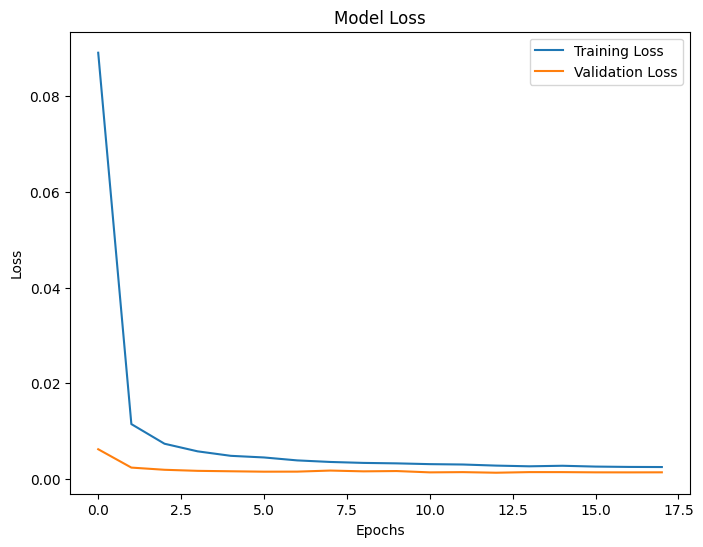

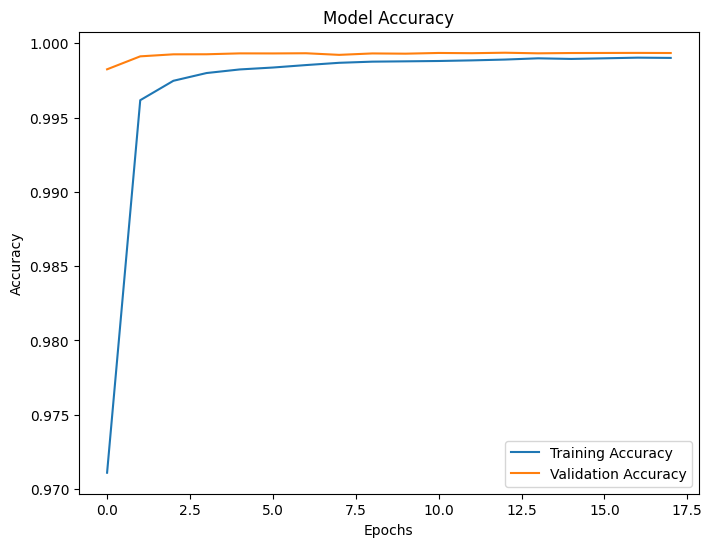

In [9]:
history = cnn

# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import confusion_matrix

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

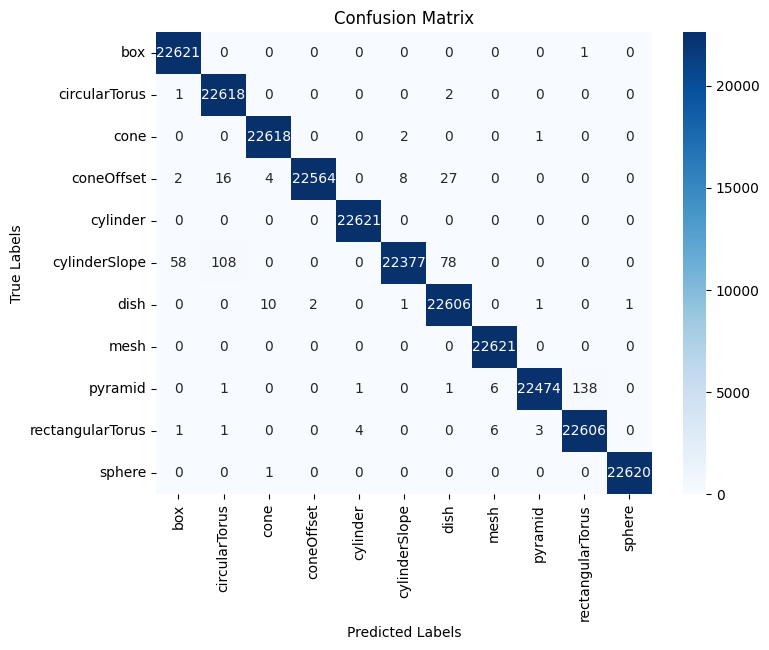

In [11]:

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=name_mapping, yticklabels=name_mapping)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()